In [115]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# List filenames

In [119]:
fasta_directory = "fastas/"
xml_directory = "pdbtm_xmls/"
topcons_pred_directory = "topcons/"

#TODO: add EGFR to the approriate list
#the order of the files must match for each list (e.g. if EGFR is listed first in the fasta_fnames, it should be first in all lists)
alpha_ids= ["1bl8", "1c17", "4qkx", "6d6t"]
beta_ids = ["1a0t", "1bxw"]


# Analysis of sequence-based prediction accuracy
We will analyze the relative accuracies of topcons, octopus, philius, polyphobius, scampi, and scoptopus for predicting alpha helical TM regions

We will also analyze the accuracy of topcons on each structure

The output of this cell should be two graphs - one showing the accuracy of each prediction method. The other showing the accuracy for each structure.

<BarContainer object of 4 artists>

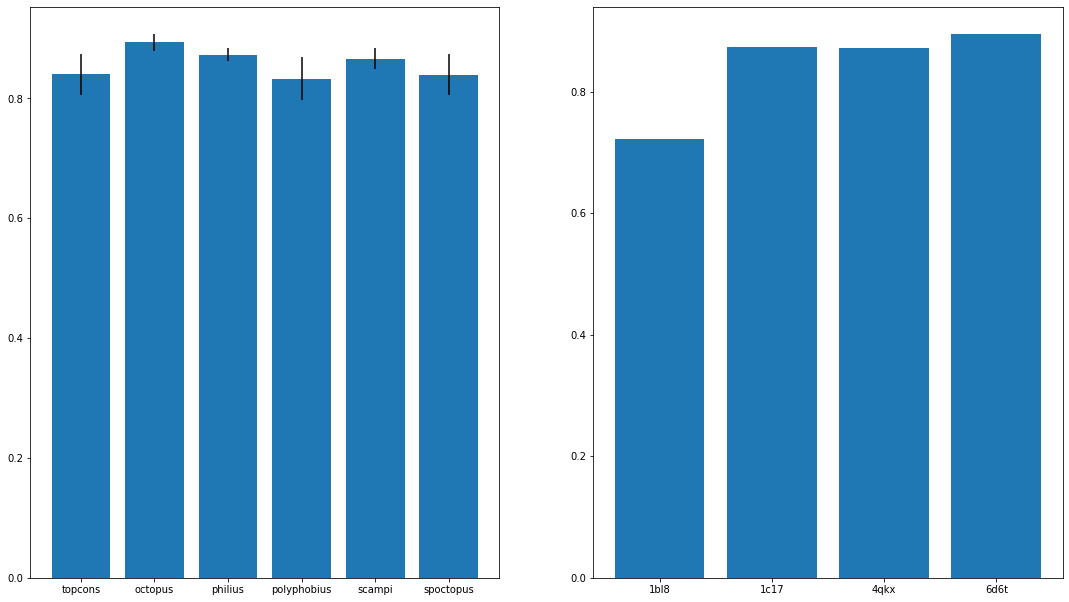

In [121]:
#load topcons predictions
prediction_methods = ["topcons", "octopus", "philius", "polyphobius", "scampi", "spoctopus"]
topcons_preds = {}
method_accuracies = {}
seq_lengths = {}
avg_accuracies = {}
std_accuracies = {}
for m in prediction_methods:
    topcons_preds[m] = {}
    method_accuracies[m] = {}
    avg_accuracies[m] = 0
    std_acucracies[m] = 0

#get topcons predictions from file
for i in alpha_ids:
    topcons_file = open(topcons_pred_directory + i + ".txt")
    next_type = "none"
    for line in topcons_file:
        if "TOPCONS2" in line or "Generated" in line or "reliability" in line:
            continue
        if next_type != "none":
            topcons_preds[next_type][i] = line.replace("\n","")
            next_type = "none"
        for m in prediction_methods:
            if m in line.lower():
                next_type = m
    seq_lengths[i] = len(topcons_preds["topcons"][i])
                
#get values from xml files
pdbtm_structs = {}
for i in alpha_ids:
    struct_seq = ""
    xml_fname = xml_directory + i + ".xml"
    tree = ET.parse(xml_fname)
    root = tree.getroot()
    for child in root:
        if "CHAINID" in child.attrib and child.attrib['CHAINID']== 'A':
            chain_tree = child
    first = True
    for child in chain_tree:
        if "seq_beg" not in child.attrib:
            continue
        seq_beg = int(child.attrib["seq_beg"])
        seq_end = int(child.attrib["seq_end"])
        struct_type = child.attrib["type"]
        if first and seq_beg != 1:
            for index in range(1, seq_beg):
                struct_seq += "U"
            
        first = False
        for index in range(seq_beg, seq_end+1):
            struct_seq += struct_type
    for index in range(seq_end, seq_lengths[i]):
        struct_seq += "U"
    pdbtm_structs[i]  = struct_seq
            
        
#TODO: calc total and individual structure accuracies
#because topcons and pdb tm use different annotation types, we will only consider helices and non helices
#we will also ignore any postions that were not defined in the pdbtm (annotated as U for unknown)
#for topcons, the helix annotation is M
#for pdbtm, the helix annotation is H

#TODO: determine accuracy for each method and protein, fill in the method_accuracy dictionary with accuracy for each method
#and structure

#average accuracies
#TODO: calculate the average accuracy over all strucutres for each method and the standard deviation or standard error
#for each method
#put results in the avg_accuracies dictionary and std_accuracies dictionary, respectively


#make bar graphs
figure, axes = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18.5, 10.5)
axes[0].bar(avg_accuracies.keys(),avg_accuracies.values(),yerr=std_accuracies.values())
axes[1].bar(method_accuracies["topcons"].keys(),method_accuracies["topcons"].values())

# Analysis of amino acid preference
We will analyze the amino acid distribution for four types of structures:
- not membrane associated
- TM Helix
- TM beta bundle
- Membrane loop (loop that dips into the membrane)
- Interfacial helix (helix close to but not inside membrane)

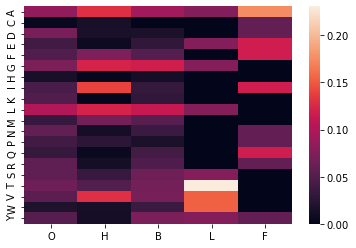

In [122]:
all_ids = alpha_ids + beta_ids
types = ["O", "H", "B", "L", "F"]
aas= ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P","Q", "R", "S", "T", "V", "W", "Y"]
aas_by_type = {}
for t in types:
    aas_by_type[t] = {}
    for a in aas:
        aas_by_type[t][a] = 0
    

for i in all_ids:
    chain_trees = []
    xml_fname = xml_directory + i + ".xml"
    tree = ET.parse(xml_fname)
    root = tree.getroot()
    for child in root:
        if "CHAINID" in child.attrib:
            seq = ""
            chain_tree = child
            for child in chain_tree:
                if "SEQ" in child.tag:
                    seq = child.text.replace(" ", "").replace("\n", "")
                    continue
                    
                seq_beg = int(child.attrib["seq_beg"])
                seq_end = int(child.attrib["seq_end"])
                struct_type = child.attrib["type"]
                
                #replace 1 and 2 with O for outside membrane
                if struct_type == "1" or struct_type == "2":
                    struct_type = "O"
                
                if struct_type not in types:
                    continue
                
                sub_seq = seq[seq_beg-1:seq_end] 
                for c in sub_seq:
                    if c not in aas:
                        continue
                    aas_by_type[struct_type][c] += 1
                    
#TODO: For each type, calculate the frequency of each amino acid

data = {'col_1': types, 'col_2': aas}
df = pd.DataFrame.from_dict(aas_by_type)

#display heatmap
sns.heatmap(df);